# Workbook to analyze zoning and SB 50 transit layer in Los Angeles


In [1]:
import osmnx as ox
from IPython.display import Image
%matplotlib inline
ox.config(log_console=True, use_cache=True)

import pandas as pd, numpy as np
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas

import matplotlib.pyplot as plot

### Load in the zoning map

In [9]:
geo_path = 'GIS/Zoning/Los_Angeles/' # select folder with data in it
mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '

la_zoning = geopandas.read_file(geo_path + 'geo_export_cba70f1c-851d-4419-8f88-6a979d8ac76c.shp').to_crs(mtc_crs)

la_zoning.head(2)

,shape_area,shape_len,zone_cmplt,geometry
0,12495.771484,449.920411,(F)CM-1-CUGU,"POLYGON ((924940.3015009164 3797138.622351959,..."
1,24992.793945,649.920555,(F)CM-1-CUGU,"POLYGON ((924936.4582080424 3797214.86467822, ..."


[]

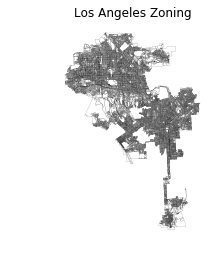

In [14]:
ax = la_zoning.plot(color='white', edgecolor='black', linewidth=.1)
ax.set_axis_off()
ax.set_title('Los Angeles Zoning')
ax.plot()

### There are so many different zoning restrictions in LA so I need to collapse them a bit to become legible

In [10]:
la_codes = pd.read_csv('GIS/Zoning/LA_res_codes.csv')
la_codes.head(2)

,zone_base,zone_detail
0,Single-Family Residential,RE40
1,Single-Family Residential,RE20


In [11]:
for i in list(range(0,len(la_codes))):
    la_zoning.loc[la_zoning['zone_cmplt'].str.contains(la_codes.loc[i,'zone_detail']), 'zone_base'] = la_codes.loc[i,'zone_base']

la_zoning.head(2)

,shape_area,shape_len,zone_cmplt,geometry,zone_base
0,12495.771484,449.920411,(F)CM-1-CUGU,"POLYGON ((924940.3015009164 3797138.622351959,...",NaN
1,24992.793945,649.920555,(F)CM-1-CUGU,"POLYGON ((924936.4582080424 3797214.86467822, ...",NaN


In [12]:
#la_zoning[la_zoning['zone_base'].isna()]

### There is something weird going on with the RD5 zoning labels

But I can't quite figure it out so I'm just going to label those as Other. There are only around 400 rows that don't work out of 58,000+ so I don't think it's a big deal. Also none of them look like they are single-family

In [13]:
values = {'zone_base': 'Other'}
la_zoning = la_zoning.fillna(value=values)

la_zoning[la_zoning['zone_base'].isna()]

,shape_area,shape_len,zone_cmplt,geometry,zone_base


In [15]:
la_zoning[la_zoning['zone_cmplt'] == 'R1-1-O-HPOZ'].head()

,shape_area,shape_len,zone_cmplt,geometry,zone_base
24250,100835.442383,1280.203859,R1-1-O-HPOZ,"POLYGON ((932309.815295619 3777574.946681563, ...",Single-Family Residential
25851,37189.670898,907.945669,R1-1-O-HPOZ,"POLYGON ((931689.5809006434 3778130.795751432,...",Single-Family Residential
27094,242637.271484,2470.753686,R1-1-O-HPOZ,"POLYGON ((929157.9286629367 3778237.570894503,...",Single-Family Residential
27186,66580.924805,1283.690678,R1-1-O-HPOZ,"POLYGON ((932531.2442437678 3774333.335647985,...",Single-Family Residential
27205,73450.746094,1421.275561,R1-1-O-HPOZ,"POLYGON ((932522.7818893215 3774508.42919381, ...",Single-Family Residential


In [16]:
la_zoning_res = la_zoning[la_zoning['zone_base'].str.contains('Two-Family Residential') |
                          la_zoning['zone_base'].str.contains('Single-Family Residential')]

la_zoning_res.head()

,shape_area,shape_len,zone_cmplt,geometry,zone_base
10,60010.854492,1000.117189,(F)R2-1-RIO,"POLYGON ((916602.1953192161 3792563.127757797,...",Two-Family Residential
11,40004.791992,900.116462,(F)R2-1-RIO,"POLYGON ((916688.1675434252 3792689.287904368,...",Two-Family Residential
12,75013.516602,1100.097912,(F)R2-1-RIO,"POLYGON ((916684.0037112483 3792780.792974097,...",Two-Family Residential
13,22413.374023,724.523170,(F)RE11-1,"POLYGON ((917321.4583059893 3806993.289399167,...",Single-Family Residential
14,24430.927734,738.796710,(F)RE11-1,"POLYGON ((917277.4079919861 3807064.130304211,...",Single-Family Residential


In [17]:
la_zoning_dissolve = la_zoning_res.dissolve(by='zone_base')

In [18]:
la_zoning_dissolve['zone_base'] = la_zoning_dissolve.index

la_zoning_dissolve = la_zoning_dissolve.reset_index(drop=True)

la_zoning_dissolve.head()

,geometry,shape_area,shape_len,zone_cmplt,zone_base
0,(POLYGON ((935257.4432151064 3750920.350281779...,22413.374023,724.523170,(F)RE11-1,Single-Family Residential
1,(POLYGON ((940321.6478597547 3748264.065307283...,60010.854492,1000.117189,(F)R2-1-RIO,Two-Family Residential


In [19]:
columns = ['zone_base','geometry']
la_zoning_trim = la_zoning_dissolve.loc[:,columns]

la_zoning_trim.head()

,zone_base,geometry
0,Single-Family Residential,(POLYGON ((935257.4432151064 3750920.350281779...
1,Two-Family Residential,(POLYGON ((940321.6478597547 3748264.065307283...


In [20]:
out_path = 'GIS/Zoning/Los_Angeles/Recode/'

la_zoning_res.to_crs({'init': 'epsg:4269'}).to_file(out_path + 'la_1-2_family.shp')

## Next step is to load in the transit layers, subset to LA City, and buffer out, and re-export

In [72]:
stop_path = 'station_id/2019-04 files/'

dtypes = {'stop_id': 'str', 'stop_name': 'str', 'agency': 'str'}
bus = pd.read_csv(stop_path + 'AllBusHQT.csv', delimiter=',', dtype=dtypes)

dtypes2 = {'stop_id': 'str', 'stop_name': 'str', 'agency': 'str'}
rail = pd.read_csv(stop_path + 'AllRail.csv', delimiter=',', dtype=dtypes2)

print(len(bus))
print(len(rail))
bus.head(1)

9800
911


,Unnamed: 0,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency
0,12,40113,Marin City Hub,-122.51107,37.871777,9.6,8.571429,11.428571,15.0,15.0,Marin Transit


In [73]:
bus['Coordinates'] = list(zip(bus.stop_lon, bus.stop_lat))
bus['Coordinates'] = bus['Coordinates'].apply(Point)
geo_bus = geopandas.GeoDataFrame(bus, geometry='Coordinates')

In [74]:
rail['Coordinates'] = list(zip(rail.stop_lon, rail.stop_lat))
rail['Coordinates'] = rail['Coordinates'].apply(Point)
geo_rail = geopandas.GeoDataFrame(rail, geometry='Coordinates')

In [75]:
geo_bus.crs = {'init': 'epsg:4269'}
print(geo_bus.crs)

geo_bus = geo_bus.to_crs(mtc_crs)
print(geo_bus.crs)

geo_rail.crs = {'init': 'epsg:4269'}
print(geo_rail.crs)

geo_rail = geo_rail.to_crs(mtc_crs)
print(geo_rail.crs)

{'init': 'epsg:4269'}
+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs 
{'init': 'epsg:4269'}
+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs 


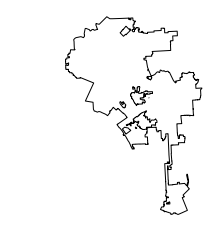

In [76]:
#load in county gis boundary to subset bus and rail stations

city_path = 'GIS/City_Boundary/'
city = geopandas.read_file(city_path + 'City_Boundary.shp').to_crs(mtc_crs)

ax = city.plot(color='white', edgecolor='black', linewidth=1)
ax.set_axis_off()
plot.show()

In [77]:
la_bus = geopandas.sjoin(geo_bus, city, how="inner", op='intersects')

la_bus.head(2)

,Unnamed: 0,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency,Coordinates,index_right,OBJECTID,CITY
2316,53,1233,37th St & Grand Ave,-118.280126,34.016707,13.333333,10.434783,13.150685,14.237288,14.237288,LADOT,POINT (935970.4727887288 3774067.890664552),0,1,IN
2317,134,1367,54th St. & Western Ave.,-118.309389,33.993177,7.500000,5.853659,7.680000,8.750000,15.000000,LADOT,POINT (933385.0726882413 3771331.02168478),0,1,IN


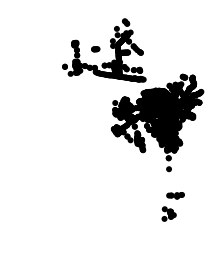

In [78]:
ax = la_bus.plot(color='black', edgecolor='none', linewidth=.1)
ax.set_axis_off()
plot.show()

In [79]:
la_rail = geopandas.sjoin(geo_rail, city, how="inner", op='intersects')

la_rail.head(2)

,Unnamed: 0,stop_id,stop_name,stop_lon,stop_lat,agency,Coordinates,index_right,OBJECTID,CITY
102,0,80122,7th Street / Metro Center Station - Metro Blue...,-118.258822,34.048610,Metro - Los Angeles.csv,POINT (937775.5799072955 3777700.93768569),0,1,IN
103,1,80121,Pico Station,-118.266118,34.040735,Metro - Los Angeles.csv,POINT (937141.8634314839 3776795.361215805),0,1,IN


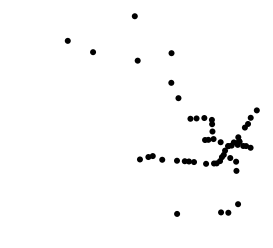

In [80]:
ax = la_rail.plot(color='black', edgecolor='none', linewidth=.1)
ax.set_axis_off()
plot.show()

In [81]:
la_bus['Coordinates'] = la_bus['Coordinates'].buffer(402.33)

la_bus.head(2)

,Unnamed: 0,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency,Coordinates,index_right,OBJECTID,CITY
2316,53,1233,37th St & Grand Ave,-118.280126,34.016707,13.333333,10.434783,13.150685,14.237288,14.237288,LADOT,"POLYGON ((936372.8027887287 3774067.890664552,...",0,1,IN
2317,134,1367,54th St. & Western Ave.,-118.309389,33.993177,7.500000,5.853659,7.680000,8.750000,15.000000,LADOT,"POLYGON ((933787.4026882412 3771331.02168478, ...",0,1,IN


In [82]:
la_rail['Coordinates'] = la_rail['Coordinates'].buffer(804.67)

la_rail.head(2)

,Unnamed: 0,stop_id,stop_name,stop_lon,stop_lat,agency,Coordinates,index_right,OBJECTID,CITY
102,0,80122,7th Street / Metro Center Station - Metro Blue...,-118.258822,34.048610,Metro - Los Angeles.csv,"POLYGON ((938580.2499072956 3777700.93768569, ...",0,1,IN
103,1,80121,Pico Station,-118.266118,34.040735,Metro - Los Angeles.csv,"POLYGON ((937946.5334314839 3776795.361215805,...",0,1,IN


In [84]:
la_bus_dissolve = la_bus.dissolve(by='CITY')

la_bus_dissolve.head()

,Coordinates,Unnamed: 0,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency,index_right,OBJECTID
CITY,,,,,,,,,,,,,,
IN,(POLYGON ((934958.5099129168 3741240.943302683...,53,1233,37th St & Grand Ave,-118.280126,34.016707,13.333333,10.434783,13.150685,14.237288,14.237288,LADOT,0,1


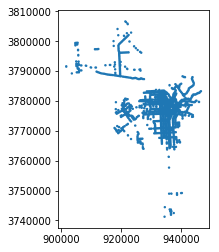

In [85]:
la_bus_dissolve.plot()

In [86]:
la_rail_dissolve = la_rail.dissolve(by='CITY')

la_rail_dissolve.head()

,Coordinates,Unnamed: 0,stop_id,stop_name,stop_lon,stop_lat,agency,index_right,OBJECTID
CITY,,,,,,,,,
IN,(POLYGON ((928244.0586695207 3763990.133563818...,0,80122,7th Street / Metro Center Station - Metro Blue...,-118.258822,34.04861,Metro - Los Angeles.csv,0,1


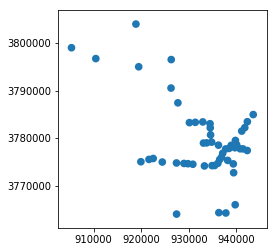

In [87]:
la_rail_dissolve.plot()

In [88]:
out_path2 = 'case_studies/los_angeles/'

la_bus_dissolve.to_crs({'init': 'epsg:4269'}).to_file(out_path2 + 'la_bus.shp')
la_rail_dissolve.to_crs({'init': 'epsg:4269'}).to_file(out_path2 + 'la_rail.shp')